In [1]:
import logging
from dask.distributed import Client, LocalCluster

In [2]:
dask_logger = logging.getLogger("distributed.utils_perf")
dask_logger.setLevel(logging.ERROR)

In [3]:
dask_cluster = LocalCluster(
    n_workers=20,
    threads_per_worker=1)
dask_client = Client(dask_cluster)

In [4]:
# dask_client

# Cleanly shut down Dask cluster

In [5]:
dask_cluster.close()

# Join English and Tibetan dataframes

In [4]:
from cai_common.data import TeiLoader, KangyurLoader

In [5]:
en_df = TeiLoader('kangyur').dataframe
en_df['location'] = en_df.location.fillna(0).astype(int)
en_df = dask_client.persist(en_df)

In [6]:
len(en_df)

In toh101, the current page was 453 which is larger than the end page 452 for volume 48, xml:id=UT22084-048-001-4468


19298

In [7]:
en_df.head()

,filename,tohoku_number,volume_number,location,text
0,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,0,The Translation The Noble Mahāyāna Sūtra Th...
1,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,394,Homage to all buddhas and bodhisattvas! Thu...
2,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,395,This is also what causes the variety of being...
3,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,396,"“Lord of nāgas, this dominion of yours like..."
4,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,397,for nonvirtuous thoughts and mental states to...


In [8]:
bo_df = KangyurLoader().remove_new_lines().dataframe
bo_df['location'] = bo_df.location.astype(int)
bo_df = dask_client.persist(bo_df)

In [9]:
len(bo_df)

65461

In [10]:
bo_df.head()

,filename,volume_number,location,text
0,v076_pages.txt,76,0,༄༅། །མདོ་སྡེ་ཨཱཾཿ་ཞུགས་སོ།།
1,v076_pages.txt,76,1,༄༅༅། །རྒྱ་གར་སྐད་དུ། པུ་ཎྱ་བ་ལ་ཨ་བ་དཱ་ན། བོད་ས...
2,v076_pages.txt,76,2,པར་བླངས་ཏེ་གནས་པར་མ་བྱས་པས་ལུས་ཞིག་སྟེ་ཤི་བའི་...
3,v076_pages.txt,76,3,བའི་ལས་དག་བྱེད་པ་ཡིན། །དམ་པ་མིན་པས་མི་རྟོགས་ཏེ...
4,v076_pages.txt,76,4,ཚེ་དང་ལྡན་པ་མ་འགགས་པ་དང་། ཚེ་དང་ལྡན་པ་ཤཱ་རིའི་...


# Load translator

In [11]:
import os

from cai_garland.utils.translator import Translator

In [12]:
translator = Translator(os.path.join("olive-cormorant-nllb", "base-600M"))
# translator = Translator(os.path.join("olive-cormorant-bart", "base-base"))

translator.num_beams = 20
translator.decoding_length = 200

# translator.prepare_context_encoder("facebook/bart-base")

translator.cuda()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'NllbTokenizer'. 
The class this function is called from is 'CAINllbTokenizerFast'.


## Create helpers from lotsawa-translate config

In [13]:
import hydra

hydra.__version__

'1.2.0'

In [14]:
with hydra.initialize(version_base="1.2", config_path="../../lotsawa/src/lotsawa/translation_config/"):
    translator_cfg = hydra.compose(config_name="translate")
    generation_cfg = translator_cfg.generation

In [15]:
translator.hard_segmenter = hydra.utils.instantiate(generation_cfg.segmentation.hard_segmentation)

translator.preprocessors = [
    hydra.utils.instantiate(preproc_func)
    for preproc_func in generation_cfg.processing.preprocessing
]

translator.soft_segmenter = hydra.utils.instantiate(
    generation_cfg.segmentation.soft_segmentation, translator=translator)

translator.soft_segment_combiner_config = getattr(generation_cfg.segmentation, "soft_segment_combiner", None)
translator.soft_segment_preprocessors = [
    hydra.utils.instantiate(preproc_func)
    for preproc_func in generation_cfg.processing.get("soft_segment_preprocessing", [])
]

translator.postprocessors = [
    hydra.utils.instantiate(preproc_func)
    for preproc_func in generation_cfg.processing.postprocessing
]

## Load processors of English text

In [16]:
with hydra.initialize(version_base="1.2", config_path="../../garland/src/cai_garland/data/dataset_prep.config/"):
    processor_cfg = hydra.compose(config_name="parallel_dataset_prep")

In [17]:
from cai_garland.utils.str_processors import ProcessorSymbolCleaningJSON

ProcessorSymbolCleaningJSON.base_dir = os.path.dirname("../../garland/src/cai_garland/data/")

In [18]:
en_processors_1 = [hydra.utils.instantiate(proc) for proc in processor_cfg.stages['naive-concats-sequenced'].dataset.preprocessing.target_lang]
en_processors_2 = [hydra.utils.instantiate(proc) for proc in processor_cfg.output.postprocessing.target_lang]

en_processors = en_processors_1 + en_processors_2
del en_processors_1, en_processors_2

In [19]:
def process_en_text(en_text):
    for processor in en_processors:
        en_text = processor(en_text)
    return en_text

In [39]:
with translator.tokenizer.as_target_tokenizer():
    tkns = translator.tokenizer.encode(
        "hi there. this is a test of what happens to periods, another test sentence.", add_special_tokens=False)
tkns

/home/eeisenst/workspace/contribs/original/transformers/src/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[294,
 2700,
 90571,
 1559,
 174,
 9,
 3068,
 305,
 2610,
 39622,
 149,
 65429,
 90575,
 11000,
 3068,
 40447,
 90571]

In [33]:
with translator.tokenizer.as_target_tokenizer():
    tkns1 = translator.tokenizer("hi there.")
with translator.tokenizer.as_target_tokenizer():
    tkns2 = translator.tokenizer("this is a test of what happens to periods,")
with translator.tokenizer.as_target_tokenizer():
    tkns3 = translator.tokenizer("another test sentence.")
tkns1, tkns2, tkns3

({'input_ids': [90590, 90590, 294, 2700, 90571, 2], 'attention_mask': [1, 1, 1, 1, 1, 1], 'tokens_fixed': [1]},
 {'input_ids': [90590, 90590, 1559, 174, 9, 3068, 305, 2610, 39622, 149, 65429, 90575, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'tokens_fixed': [1]},
 {'input_ids': [90590, 90590, 11000, 3068, 40447, 90571, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'tokens_fixed': [1]})

In [60]:
# with translator.tokenizer.as_target_tokenizer():
#     print(translator.tokenizer.eos_token_id)
translator.tokenizer.target_tokenizer.__dict__.keys()
# translator.tokenizer.target_tokenizer.lang_code_to_id[translator.tokenizer.target_tokenizer.tgt_lang]
# translator.tokenizer.target_tokenizer.bos_token_id
with translator.tokenizer.as_target_tokenizer():
    print(translator.tokenizer.encode("")[-1:])

[2]


In [34]:
with translator.tokenizer.as_target_tokenizer():
    print(translator.tokenizer.decode(tkns['input_ids']))

eng_Latneng_Latn hi there. this is a test of what happens to periods, another test sentence.</s>


In [36]:
with translator.tokenizer.as_target_tokenizer():
    print(translator.tokenizer.decode(tkns2['input_ids']))

eng_Latneng_Latn this is a test of what happens to periods,</s>


In [62]:
with translator.tokenizer.as_target_tokenizer():
    tkns1 = translator.tokenizer("hi there.", return_tensors="pt")
tkns1

{'input_ids': tensor([[90590, 90590,   294,  2700, 90571,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]]), 'tokens_fixed': [1]}

# Test of individual segments

In [87]:
# en_df.sample(frac=0.1).compute().sample(frac=0.01).sort_values('tohoku_number')
en_df[en_df.tohoku_number == 'toh257'].compute().sample(frac=0.05).sort_values('tohoku_number')
# en_df[en_df.tohoku_number == 'toh686'].compute().sample(frac=0.02).sort_values('tohoku_number')

,filename,tohoku_number,volume_number,location,text
108,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,288,tvehukṣa vanirajū dhvanamarajū vaghanapute sa...
303,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,483,Analysis is what causes the movement of the w...
277,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,457,"At that moment, within that retinue of nāg..."
207,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,387,“If you are great sages endowed with merit an...
6,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,186,"dhāraṇīs, and absorptions replete with the mo..."
192,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,372,Liberate yourselves from all forms of suffer...
227,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,407,
293,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,473,They will perform worship day and night at th...
137,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,317,"In the presence of the world with its gods, I..."
245,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,425,But will enjoy permanent happiness and freed...


In [88]:
# volume_number, location = 92, 362
volume_number, location = 66, 320

In [89]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location - 1)].compute().text.values[0]

'ལ་སྟེན་ཅིང་སྒོམ་ལ་ལན་མང་དུ་བྱེད་པ་ན་མཚན་མོ་ཇི་ལྟ་བར་ཉིན་པར་ཡང་དེ་བཞིན་དུ་ཡང་དག་པར་རྗེས་སུ་མཐོང་ཞིང་། དེ་འཇིག་རྟེན་ཐམས་ཅད་ལ་མངོན་པར་མི་དགའ་བའི་འདུ་ཤེས་སྐྱེད་དོ། །དེ་འདི་སྙམ་དུ་སེམས་ཏེ། བདག་ནི་རྒ་ཤིའི་འཇིགས་པས་གནོད་པར་གྱུར་པ་ཡིན་པས་གང་བདག་གིས་རྒ་ཤིའི་རྔ་བོ་ཆེ་འདི་མ་ལུས་པར་གཅག་གོར་མ་ཆག་སྙམ་མོ། །ཇི་ལྟར་བདག་གིས་རྒ་ཤིའི་རྔ་བོ་ཆེ་མ་ལུས་པར་གཞིག་པར་ནུས་ཞེ་ན། གང་བདག་གིས་རུས་པའི་ཕུང་པོ་འདི་ལ་ཤིན་ཏུ་སོ་སོར་བརྟག་པར་བྱས་པས་མ་ལུས་པར་གཞིག་པར་བྱ་གོར་མ་ཆག་སྙམ་ནས་དེ་ཐམས་ཅད་དང་ལྡན་པའི་རུས་པའི་ཕུང་པོ་འདི་ལ་སོ་སོར་རྟོག་པར་བྱེད་དེ། གང་དེ་ཐམས་ཅད་ལ་དཀར་པོའི་འདུ་ཤེས་ཡིད་ལ་བྱེད་པ་འདི་ནི་དེའི་ཞི་གནས་སུ་འགྱུར་རོ། །དེ་འདི་ནི་བདག་གི་མགོའི་རུས་པའོ་ཞེས་བྱ་བ་ནས་དེ་བཞིན་དུ་འདི་ནི་བདག་གི་རྐང་པའི་མཐེ་བོའི་རུས་པའོ་ཞེས་བྱ་བའི་བར་དུ་དེ་ལྟར་སོ་སོར་རྟོག་པར་བྱེད་ཅིང་རྒ་ཤིའི་རྔ་བོ་ཆེ་འདི་གཞིག་པར་བྱ་བའི་ཕྱིར་བདག་གིས་གནས་གང་དུ་ལྷག་མཐོང་གིས་བརྩམ་པར་བྱ་སྙམ་མོ། །དེ་འདི་སྙམ་དུ་སེམས་ཏེ། ཁ་དང་སྣ་གཉིས་ཀྱི་རླུང་འདུས་པས་རྒ་ཤིའི་རྔ་བོ་ཆེ་རང་གི་རུས་པའི་ཕུང་པོ་འདི་མ་ལུས་པར་གཞིག་པར་བྱའོ་སྙམ་ནས་དེ་སྣའི་རྩེ་མོར་རླུང་འདུས་པས་ཡང་དག་པར་རྩོམ་པར་བྱེ

In [90]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location)].compute().text.values[0]

'སྙམ་ནས་དེ་དེ་ལྟར་རླུང་འདུས་པས་ཕྱི་རོལ་གྱིས་གཟུགས་སྣང་བ་གང་ཅི་ཡང་རུང་བ་ཐམས་ཅད་རླུང་གིས་རྣམ་པར་འཇིག་པར་བྱེད་དོ། །དེ་རྣམ་པ་ཐམས་ཅད་དུ་ནང་ངམ་ཕྱི་རོལ་གྱི་གཟུགས་སྣང་བ་ཐམས་ཅད་སྤངས་ནས་བྱེ་བྲག་ཏུ་ཡིད་ལ་བྱེད་པ་འདི་ནི་སྟོང་པ་ཉིད་ཀྱི་ཡན་ལག་གཉིས་པའོ། །ཡང་དེ་འདི་སྙམ་དུ་སེམས་ཏེ། བདག་གིས་གཟུགས་སྣང་བ་གང་སྤངས་པ་ཐམས་ཅད་ནི་བདག་ལ་སྟོང་པར་སྣང་གི་གཞན་ནི་མ་ཡིན་ནོ། །དེས་ན་བདག་གི་རླུང་དུ་ཀུན་ཏུ་རྟོག་པའི་སེམས་འདི་ཡང་ཤིན་ཏུ་རྣམ་པར་གྲོལ་བ་མ་ཡིན་པས་དེ་བདག་གིས་སྤང་བར་བྱའོ། །ཆོས་ནི་གང་དུ་ཡང་འོང་བ་མེད། གང་དུ་ཡང་འགྲོ་བ་མེད་དེ། དེ་དེ་ལྟར་འགྲོ་བ་མེད་པའི་ཚུལ་ལམ། བདག་ཉིད་འགྲོ་བའི་ཚུལ་གྱིས་རྟོག་པ་སྤོང་བར་བྱེད་དེ་འདི་ནི་སྟོང་པ་ཉིད་ཀྱི་ཡན་ལག་གསུམ་པའོ། །ཡང་དེ་འདི་སྙམ་དུ་སེམས་ཏེ། ཅི་འདུས་བྱས་ཐམས་ཅད་ལ་དེ་ཁོ་ན་ཡང་དག་པ་ཅི་ཡང་ཡོད་དམ་སྙམ་ནས་དེ་ཡང་དག་པ་མངོན་སུམ་དུ་གྱུར་པ་དེ་ཤེས་པར་བྱས་ཏེ། ཀུན་འབྱུང་བའི་ཆོས་གང་ཅི་ཡང་རུང་བ་ཐམས་ཅད་འགོག་པའི་ཆོས་སུ་རིག་པར་བྱས་ནས་དེས་ཁམས་གསུམ་པ་ཐམས་ཅད་མེད་ཅིང་ཡང་དག་པ་མ་ཡིན་པར་ཤེས་ཏེ། དེའི་འདུ་བྱེད་ཤིན་ཏུ་སྦྱངས་ཤིང་ཞི་བར་འགྱུར་བ་འདི་ནི་སྟོང་པ་ཉིད་ཀྱི་ཡན་ལག་བཞི་པའོ། །ཁ་ཅིག་ནི་འདིར་འབྲས་བུ་དང་པོ་ལ་གནས་པར་བྱེད

In [91]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location + 1)].compute().text.values[0]

'སྟོང་པ་ཉིད་དང་རྗེས་སུ་འཐུན་པའི་གཟུངས་སྔགས་བརྒྱད་པ་ཡིན་ཏེ། སོ་སོའི་སྐྱེ་བོ་དང་ཐུན་མོང་མ་ཡིན་པ་བདེན་པ་དང་རྗེས་སུ་འཐུན་པའི་གཟུངས་སྔགས་མཐུ་ཆེ་བ། ཕན་ཡོན་ཆེ་བ། འདོད་པའི་འདོད་ཆགས་ཐམས་ཅད་ཡང་དག་པར་ཟད་པར་བྱེད་པ། གཟུགས་དང་གཟུགས་མེད་པའི་འདོད་ཆགས་ཐམས་ཅད་ཡང་དག་པར་ཟད་པར་བྱེད་པ་ཞེས་བྱ་བ་ནས་སྡུག་བསྔལ་གྱི་ཁུར་འདོར་བར་བྱེད་པ་ཞེས་བྱ་བའི་བར་ཡིན་ནོ། །དེ་ནི་དེ་བཞིན་གཤེགས་པ་རི་དབང་རྒྱལ་པོས་ང་ལ་སྟོང་པ་ཉིད་དང་རྗེས་སུ་འཐུན་པའི་གཟུངས་སྔགས་བྱང་ཆུབ་སེམས་དཔའ་སེམས་དཔའ་ཆེན་པོ་སྤོས་ཀྱི་གླང་པོ་ཆེའི་ལག་ནས་བསྐུར་བ་དང་འདུས་པ་འདི་ལ་ངས་བཤད་པ་ལ་དད་པ་སྦྱིན་པར་མཛད་པ་ཡིན་ནོ། །བསྟན་པ་འདི་བཤད་པ་ན་དེར་སེམས་ཅན་བྱེ་བ་འབུམ་ཕྲག་དགུ་བཅུ་རྩ་གཉིས་འབྲས་བུ་དང་པོ་ལ་གནས་པར་གྱུར་ཏོ། །འབུམ་ཕྲག་དྲུག་ཅུ་ནི་ལེན་པ་མེད་པར་ཟག་པ་རྣམས་ལས་སེམས་རྣམ་པར་གྲོལ་ལོ། །སྔོན་ལས་བྱས་པའི་སེམས་ཅན་ཁྲག་ཁྲིག་འབུམ་ཕྲག་དགུ་བཅུ་རྩ་དགུ་ནི་སྟོང་པ་ཉིད་དང་རྗེས་སུ་འཐུན་པའི་གཟུངས་སྔགས་ཐོབ་པར་གྱུར་ཏོ། །སྲོག་ཆགས་བརྒྱད་ཁྲི་ནི་རང་བྱུང་ཅན་གྱི་གཟུངས་སྔགས་ཐོབ་པར་གྱུར་ཏོ། །དེར་སེམས་ཅན་དཀྲིགས་ཕྲག་དྲུག་ཅུས་ནི་བླ་ན་མེད་པ་ཡང་དག་པར་རྫོགས་པའི་བྱང་ཆུབ་ཏུ་སེམས་བསྐྱེད་ཅིང་བླ་ན་མེད་པ་ཡང་དག་པར་ར

In [92]:
en_df[(en_df.volume_number == volume_number) & (en_df.location == location)].compute()

,filename,tohoku_number,volume_number,location,text
140,066-015_toh257-the_sutra_of_the_quintessence_o...,toh257,66,320,"By doing so, all outer appearances of form wi..."


In [93]:
en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

In [94]:
en_text = en_df[(en_df.volume_number == volume_number) & (en_df.location == location)].compute().text.values[0]
en_text

' By doing so, all outer appearances of form will be disintegrated by those winds. Having entirely abandoned all the inner and outer appearances of form, they will specifically contemplate this. This is the second branch of emptiness.  “Again, they will think, ‘All the material appearances I have abandoned appear to me as emptiness and not in any other way. However, since my mind that conceives the winds is not entirely liberated, I must abandon that too!’ Since phenomena do not come from or go anywhere, they will give up conceptualizing in terms of going or the absence of going. This is the third branch of emptiness.  “Again, they will wonder, ‘Is there anything true at all among all conditioned things?’ Thinking in that way, they will directly understand what is true. Knowing that all phenomena that arise are phenomena that cease, they will understand that all three realms are nonexistent and unreal, and their formations will become utterly purified and pacified. This is the fourth b

In [95]:
# bo_text = "།རིགས་ཀྱི་བུ་ཁྱོད་ཀྱང་ད་ལྟར་ཏིང་ངེ་འཛིན་ལས་ལངས་པས་རིགས་ཀྱི་བུ་ཁྱོད་ད་མི་མཇེད་ཀྱི་འཇིག་རྟེན་གྱི་ཁམས་སུ་འགྲོ་བར་བྱའོ།"
# bo_text = "།རིགས་ཀྱི་བུ་སངས་རྒྱས་ཀྱི་ཞིང་མི་མཇེད་དེ་ན་ནི་སེམས་ཅན་རྣམས་ཤིན་ཏུ་སྲེད་པའི་ཀུན་ཏུ་སྦྱོར་བ་དང་ལྡན་ཞིང་སྲིད་པའི་ལྟུང་ལ་བཏགས་པ་དག་ཡིན་ཏེ།"
# bo_text = "སངས་རྒྱས་ཀྱི་ཞིང་དེ་ན་ནང་ན་ཡང་བུད་མེད་གཟུགས་མི་སྡུག་པ་དང་། ཚུལ་དུ་མི་ཤིས་པ་དང་། མཆོག་ཏུ་གཟུགས་ཀྱི་རྒྱགས་པས་དྲེགས་པ་དང་།"
# bo_text = "དྲི་ང་བ་དང་། མི་གཙང་བ་དང་། གཙང་སྦྲར་སྤྱོད་པའི་རྒྱགས་པས་དྲེགས་པ་དང་།"
# bo_text = "ངོ་གཉིས་བྱེད་པ་དང་། བདེན་པ་མ་ཡིན་པའི་ཚིག་སྨྲ་བ་དང་། ཚངས་པར་སྤྱོད་པར་ང་རྒྱལ་བྱེད་པ་དང་།"
# bo_text = "།བུད་མེད་ཀྱི་ཉེས་པས་དགེ་བའི་རྩ་བ་ཐམས་ཅད་ལས་ཡོངས་སུ་ཉམས་པ་དག་དང་། ངན་སོང་བ་དག་དང་། སེམས་ཅན་དམྱལ་བ་པ་དག་ཏུ་འགྱུར་བ་ཡིན་ནོ།"
# bo_text = "།རིགས་ཀྱི་བུ་ཁྱེད་དེ་བཞིན་གཤེགས་པ་ཤཱཀྱ་ཐུབ་པ་དེ་ལ་ངའི་བཀས་ཞུ་བའི་ཕྱིར་ངའི་བཀས་མི་མཇེད་ཀྱི་འཇིག་རྟེན་གྱི་ཁམས་སུ་འགྲོ་བར་སྤྲོ་ན། དེར་ཉི་མའི་སྙིང་པོའི་ཆོས་ཀྱིས་གནས་པ་ཀླུའི་ཡུལ་རྣམ་པར་འཇིག་པར་མཛད་པའི་འོད་ཟེར་གྱི་ལེའུ་སེམས་ཅན་རྣམས་ཀྱི་ལས་ཟད་པར་འགྱུར་བའི་གཟུངས་སྔགས་ལ་ང་དད་པ་སྦྱིན་པར་མཛད་དོ།"

# bo_text = "།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ།"
# bo_text = "སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ།"
# bo_text = "།དེ་ནས་དོན་ཡོད་པ་པདྨའི་གཙུག་ཏོར་དྲན་པ་ཙམ་གྱིས། བྱ་བ་ཐམས་ཅད་ནི་གཉིས་སུ་འགྱུར་ཏེ།"
# bo_text = "གཞོན་ནུ་དང་། སྡེ་དཔོན་དང་། དེ་བཞིན་དུ་རྒྱལ་པོ་ཆེན་པོ་བཞི་དུས་རྟག་ཏུ་རིག་སྔགས་འཆང་གི་རྗེས་སུ་འབྲང་བར་བྱེད་དོ།"
bo_text = "དེ་བཞིན་དུ་རྒྱལ་པོ་ཆེན་པོ་བཞི་དུས་རྟག་ཏུ་རིག་སྔགས་འཆང་གི་རྗེས་སུ་འབྲང་བར་བྱེད་དོ།"

bo_text = "།ཆོས་ནི་གང་དུ་ཡང་འོང་བ་མེད། གང་དུ་ཡང་འགྲོ་བ་མེད་དེ།"

In [96]:
bo_text, translator.translate(bo_text)

/home/eeisenst/workspace/contribs/original/transformers/src/transformers/tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


('།ཆོས་ནི་གང་དུ་ཡང་འོང་བ་མེད། གང་དུ་ཡང་འགྲོ་བ་མེད་དེ།',
 'phenomena do not come from anywhere, and they do not go anywhere.')

In [77]:
# en_text = 'This maṇḍala brings every accomplishment and causes the vidyā holder’s realization, merit, and splendor to grow. It is effective for removing all diseases and eradicating evil and vice. It heals wounds, injuries, and broken bones and destroys poisons and kākhordas. It also removes chronic diseases, ailments, and fevers.'
# en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat."

# en_text = 'This maṇḍala brings every accomplishment and causes the vidyā holder’s realization, merit, and splendor to grow. It is effective for removing all diseases and eradicating evil and vice.'
# en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco."

# en_text = 'it is the accomplishment of removing all illness. it destroys bad karma and bad karma.'
# en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt."

In [97]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [98]:
from torch.nn.functional import log_softmax

def get_total_logits(bo_text, cur_en_text):
    bo_tokens = translator.tokenizer(bo_text, return_tensors="pt")
    with translator.tokenizer.as_target_tokenizer():
        en_tokens = translator.tokenizer(cur_en_text, return_tensors="pt")

    model_inputs = {
        'input_ids': bo_tokens.input_ids.to(translator.model.device),
        'attention_mask': bo_tokens.attention_mask.to(translator.model.device),
        # 'decoder_input_ids': en_tokens.input_ids.to(translator.model.device),
        # 'decoder_attention_mask': en_tokens.attention_mask.to(translator.model.device),
        'labels': en_tokens.input_ids.to(translator.model.device),
    }

    return -float(translator.model(**model_inputs).loss.to("cpu"))# / en_tokens.input_ids.shape[-1]

    model_logits = translator.model(**model_inputs).logits[0].to("cpu")
    # total_logit = float(log_softmax(model_logits[1:][:,en_tokens.input_ids[0][:-1].to("cpu")].diagonal()).sum()) / model_logits.shape[0]
    total_logit = float(log_softmax(model_logits[:,en_tokens.input_ids[0].to("cpu")].diagonal()).sum()) / model_logits.shape[0]
    return(total_logit)

In [99]:
from tqdm.auto import tqdm

def score_segment(bo_segment, en_text, tqdm=tqdm):
    all_logits = []
    # splits = [t.strip() for t in remove_accents(en_text.lower()).replace("!", ".").replace("“", "").replace("—", ", ").split('.')]
    splits = [t.strip() for t in en_text.split(',') if len(t) > 0]
    for start_idx in tqdm(range(len(splits))):
        for end_idx in tqdm(range(start_idx + 1, len(splits) + 1), leave=False):
            cur_en_text = '. '.join(splits[start_idx:end_idx]) + '.'
            all_logits.append(((cur_en_text, start_idx, end_idx), get_total_logits(bo_segment, cur_en_text)))
    return sorted(all_logits, key=lambda x: -x[1])

In [100]:
score_segment(bo_text, en_text)[:3]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/eeisenst/workspace/compassionai/garland/src/cai_garland/models/cai_nllb_tokenizer.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(
/home/eeisenst/workspace/contribs/original/transformers/src/transformers/models/encoder_decoder/modeling_encoder_decoder.py:642: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[(('they will understand that all three realms are nonexistent and unreal.',
   11,
   12),
  -2.634517192840576),
 (('their lives will also be exhausted.', 18, 19), -2.981154680252075),
 (('they will directly understand what is true. Knowing that all phenomena that arise are phenomena that cease. they will understand that all three realms are nonexistent and unreal.',
   10,
   12),
  -3.5245556831359863)]

# Test for longer text with segmentation

## Load some longer Tibetan text

In [36]:
volume_number, location = 92, 362

In [37]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location - 1)].compute().text.values[0]

'རས་གཟིགས་དབང་ཕྱུག་གིས། དོན་ཡོད་ཞགས་པའི་སྙིང་པོའི་གསང་སྔགས་འདི་སྨྲས་སོ། །ཨོཾ་ཨ་མོ་གྷ་པཱ་ཤ་ཧྲྀ་ད་ཡ་པདྨོཥྞཱི་ཥ་ཀུ་མཱ་ར་བེ་ཥ་དྷ་ར། པདྨེ་ཤྭ་ར། ཨཱ་བེ་ཤ་ཡ། སརྦ་ཨ་མོ་གྷ་ཀུ་ལ་ས་མ་ཡ་ཧྲྀ་ད་ཡ། སརྦ་སིདྡྷི་ཨ་མོ་གྷ་པྲ་ཡཙྪ་པདྨ། པདྨ་ཧཱུྃ་ཧཱུྃ་ན་མ་སྟུ་ཏེ་སྭཱ་ཧཱ། འདི་ནི་དོན་ཡོད་ཞགས་པའི་སྙིང་པོ་བཀླགས་པས་གྲུབ་པའི་སྒྲུབ་ཐབས་སོ། །ཨོཾ་ཨ་མོ་གྷ་པདྨོ་ཥྞཱི་ཥེ་ཤྭ་ར། པདྨེ་ཤྭ་ར། ས་མནྟཱ་ཡ་སརྦ་ཏ་ཐཱ་ག་ཏཱ་ནཱཾ། ཨ་མོ་གྷ་པདྨོཥྞཱི་ཥ་ས་མ་ཡ་ཨཱ་ཀརྵ་ཡ། པྲ་བེ་ཤ་ཡ། སརྦ་ཀརྨ་སིདྡྷིམྨེ་པྲ་ཡཙྪ་ཨ་བ་ལོ་ཀི་ཏེ་ཤྭ་ར་ཧཱུཾ་ཧཱུཾ། མ་ཧཱ་པདྨོཥྞཱི་ཥ་བྷུ་ཛེ་སྭཱ་ཧཱ། རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་སོ། །ཨོཾ་ཨ་ཧཱ་ཙནྜ་པདྨེ་ཤྭ་ར་བི་བི་དྷ་རཱུ་པ། བི་ཀ་ཊ། པདྨ་དཾཥྜ་ཀེ་རཱ་ལ་བྷཱི་ཥ་ཎ། བཱཀྟྲ་སརྦ་དུཥྚ་ཧྲྀ་ད་ཡཾ། ཁཱ་ད་ཡ། བིགྷ་ནཱཾ། པདྨ་དྷྲི་ཀ །ཙི་ཊི། དྲི་ཊི་ཧཱུཾ་སྭཱ་ཧཱ། ཁྲོ་བོའི་རྒྱལ་པོའི་རིགས་ཀྱི་སྙིང་པོའོ། །ནང་གི་དཀྱིལ་འཁོར་གསང་བའི་ལས་རྣམས་སོ། །ཨོཾ་ཨ་མོ་གྷ་པདྨོཥྞཱི་ཥ་པདྨ་པཱ་ཤ་ཀྲོ་དྷ་ཀ །མོ་ཡ་ཀརྨ་པྲ་བེ་ཤ་ཡ་མ་ཧཱ་བཱ་ཤུ་པ་ཏི། ཡ་མ། བ་རུ་ཎ། ཀུ་བེ་ར། བྲཧྨ་བེ་ཥ་དྷ་ར། མ་ཧཱ་ཙཎྜ་བེ་ག །ཨ་མོ་གྷ་ཀུ་ལས་མ་ཡ། པདྨེ་ཧཱུཾ་ཧཱུཾ། ཁྲོ་བོའི་རྒྱལ་པོ་དོན་ཡོད་ཞགས་པའི་པདྨ་གཙུག་ཏོར་གྱི་སྙིང་པ

In [38]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location)].compute().text.values[0]

'པའི་དཔལ་ཐོབ་བོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ། །པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ། བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ། །པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ། དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ། རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ། །སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། །རིགས་ཀྱི་རིག་པས་ལྷའི་དབང་ཕྱུག་དང་། ལྷའི་ཚོགས་རྣམས་ཀྱི་དབང་ཕྱུག་ཏུ

In [39]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location + 1)].compute().text.values[0]

'དང་། སྲིན་པོ་དང་། འབྱུང་པོ་དང་། གཟའ་དང་། བརྗེད་བྱེད་དང་། མི་བཟད་པ་དེ་རྣམས་ཐམས་ཅད་ཁྲོ་བོའི་རྒྱལ་པོ་དྲན་པ་ཙམ་གྱིས་འཇིགས་པར་འགྱུར་རོ། །ཁྲོ་བོའི་རྒྱལ་པོའི་གསང་བ་ཐམས་ཅད་ཀྱི་རིགས་ཀྱི་དམ་ཚིག་ལ་གནས་པ་དང་། དཀྱིལ་འཁོར་དུ་ཕྱག་རྒྱ་གནས་པ་དང་། གསང་སྔགས་ཀྱི་ལྷ་གཞན་གང་ཡིན་པ་རྣམས་ཀྱིས་ཁྲོ་བོའི་རྒྱལ་པོ་དྲན་པ་ཙམ་གྱིས་དེ་རྣམས་ཐམས་ཅད་རིག་སྔགས་འཆང་ལ་སྐྱབས་སུ་འགྲོ་བར་བྱེད་དོ། །དེ་རྣམས་ཐམས་ཅད་རྗེས་སུ་འབྲང་བར་འགྱུར་ཞིང་གནས་པར་བྱེད་དོ། །འགའ་ཞིག་གང་དུ་འགྲོ་བའམ་འདུག་པ་དེ་ལ་དབང་པོ་དང་། སྐབས་གསུམ་པའི་ལྷ་དང་། ཚངས་པ་དང་། ཁྱབ་འཇུག་དང་། དབང་ཕྱུག་ཆེན་པོ་དང་། གཤིན་རྗེ་དང་། ཆུ་ལྷ་དང་། ཀླུའི་རྒྱལ་པོ་རྒྱ་མཚོ་དང་། དགའ་བོ་དང་། ཉེ་དགའ་བོ་དང་། གཞོན་ནུ་དང་། སྡེ་དཔོན་དང་། དེ་བཞིན་དུ་རྒྱལ་པོ་ཆེན་པོ་བཞི་དུས་རྟག་ཏུ་རིག་སྔགས་འཆང་གི་རྗེས་སུ་འབྲང་བར་བྱེད་དོ། །ཐེ་ཚོམ་མེད་དོ། །ཁྲོས་པའི་ལས་རྣམས་སམ། དེ་བཞིན་དུ་དྲག་པོའི་ལས་རྣམས་ཐམས་ཅད་ཀྱང་ཧཱུཾ་ཡིག་ཙམ་གྱིས་དེ་ལ་དངོས་གྲུབ་མཐོང་ངོ་། །ཕྱིར་རྒོལ་བ་དང་། དགྲ་དང་། སེམས་ཅན་མ་རུངས་པ་ཤིན་ཏུ་མི་བཟད་པ་རྣམས་དང་། ཕ་རོལ་གྱི་དམག་ཚོགས་དང་འཇིགས་པ་དང་། རྣམ་པར་འགྲས་པའི་སྐྱེ་བོ་དང་། སྡིག་པ་དེ་རྣམས་ཐམས་ཅད་ཧཱུཾ་ཡ

In [40]:
bo_text = "བླ་ན་མེད་པའི་དཔལ་ཐོབ་བོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ། །པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ། བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ། །པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ། དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ། རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ། །སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། །རིགས་ཀྱི་རིག་པས་ལྷའི་དབང་ཕྱུག་དང་། ལྷའི་ཚོགས་རྣམས་ཀྱི་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །རྟག་ཏུ་ཡང་གནོད་སྦྱིན་རྣམས་དང་། སྲིན་པོ་རྣམས་སུ་གྱུར་པ་དང་། དྲི་ཟ་རྣམས་དང་། གནོད་སྦྱིན་རྣམས་དང་། སྲིན་པོ་རྣམས་ཀྱི་དེ་བཞིན་ཉིད་དུ་ཐམས་ཅད་དུ་རྒྱལ་པོ་དང་། དབང་ཕྱུག་ཏུ་རྟག་ཏུ་འགྱུར་ཏེ་ཐེ་ཚོམ་མེད་དོ། །ནམ་མཁའ་ལྡིང་རྣམས་དང་། མིའམ་ཅི་རྣམས་དང་། ལྟོ་འཕྱེ་ཆེན་པོ་རྣམས་དང་། ཐམས་ཅད་དུ་ཇི་སྲིད་བྱང་ཆུབ་ལ་ཡང་དག་པར་གནས་ཀྱི་བར་དུ་རིགས་ཀྱི་རྒྱལ་པོར་འགྱུར་རོ། །དེ་ནས་ཁྲོ་བོའི་རྒྱལ་པོ་དྲན་པ་ཙམ་དང་དྲག་པོ་དེ་ཡིད་ལ་སེམས་པ་ཙམ་གྱི་མོད་ལ། འཕྲལ་དུ་རི་རབ་ལྟུང་བར་བྱེད་ཅིང་། ཁོར་ཡུག་གི་རི་རྣམ་པར་འཐོར་བར་བྱེད་དོ། །རྒྱ་མཚོ་ཆེན་པོ་ཀུན་ནས་དཀྲུག་ཅིང་། རྒྱ་མཚོ་ཆེན་པོ་ཉེ་བར་སྐྱེ་བར་བྱེད་དོ། །ཀུན་དུ་གསལ་བར་བྱེད་དོ། །ཀླུའི་གནས་ཐམས་ཅད་དུ་ཀླུའི་གནས་འབར་བར་ཡང་བྱེད་དོ། །བགེགས་དང་ལོག་པར་འདྲེན་པ་ཐམས་ཅད་ཀྱི་སྐད་ཅིག་ཙམ་གྱིས་སྟེང་དུ་བདུག་པར་བྱེད་དོ། །གནོད་སྦྱིན་དང་།"
bo_text

'བླ་ན་མེད་པའི་དཔལ་ཐོབ་བོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ། །པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ། བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ། །པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ། དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ། རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ། །སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། །རིགས་ཀྱི་རིག་པས་ལྷའི་དབང་ཕྱུག་དང་། ལྷའི་ཚོགས་རྣམས་ཀྱི་དབ

In [41]:
en_text = en_df[(en_df.volume_number == volume_number) & (en_df.location == location)].compute().text.values[0]
en_text

' If he mindfully repeats the mantra of the lord of the family, he will obtain the auspicious accomplishment of the lord of the family in the maṇḍala of Padmoṣṇīṣa. Family lords, as well as the mantra and vidyā kings who rule over the family lords’ auspicious accomplishments, will arrive and grant the vidyā holder every supreme accomplishment. Followed by Padmapāṇi, he will win the accomplishments of the amogha family. These kings of mantras will be accomplished through recitation; there is no doubt about this.  “Accomplishment in the Padmoṣṇīṣa family belongs to the great lotus maṇḍala, the maṇḍala of Amoghapāśa, where one becomes accomplished through recitation. Through mere recitation, the vidyā holder will become the lord of the family and the king of the vidyādharas—a sovereign lord in every respect. Using the rites and mudrās of the corresponding maṇḍalas, he will join the same family as the bodhisattvas and will perform the function of a king in every respect. Using the family v

In [42]:
segments = list(translator.segment(bo_text))
segments

Hard segments:   0%|          | 0/1 [00:00<?, ?it/s]

Segmenting:   0%|          | 0/39 [00:00<?, ?it/s]

['།བླ་ན་མེད་པའི་དཔལ་ཐོབ་བོ།',
 '།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ།',
 'ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ།',
 '།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ།',
 '།པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ།',
 'བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ།',
 '།པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ།',
 'དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ།',
 'རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ།',
 '།དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ།',
 '།སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ།',
 '།རིགས་ཀྱི་ར

In [43]:
en_text = process_en_text(en_text)

In [44]:
segment_scores = {}
for segment in tqdm(segments, leave=False):
    segment_scores[segment] = score_segment(segment, en_text, tqdm=lambda *args, **kwargs: tqdm(*args, disable=True, **kwargs))

  0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
final_matches = {}

In [46]:
while len(segment_scores) > 0:
    best_match = max(
        [(segment, scores[0]) for segment, scores in segment_scores.items()],
        key=lambda x: x[1][1])
    best_bo, ((best_en, best_en_start, best_en_end), best_score) = best_match
    final_matches[best_bo] = (best_en, best_score)

    del segment_scores[best_bo]

    new_segment_scores = {}
    for segment, scores in segment_scores.items():
        new_segment_scores[segment] = [((en, en_start, en_end), score) for (en, en_start, en_end), score in scores if not (best_en_start >= en_start and best_en_end <= en_end)]
    segment_scores = new_segment_scores

In [47]:
final_matches

{'།གནོད་སྦྱིན་དང་།།': ('as well as of yaksas.', -1.5338767766952515),
 '།སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ།': ('he will become king in hundreds of thousands of buddha fields.',
  -1.6311500072479248),
 '།ཀུན་དུ་གསལ་བར་བྱེད་དོ། །ཀླུའི་གནས་ཐམས་ཅད་དུ་ཀླུའི་གནས་འབར་བར་ཡང་བྱེད་དོ།': ('all naga dwellings will burn.',
  -1.9746745824813843),
 '།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ།': ('he will obtain the auspicious accomplishment of the lord of the family in the mandala of padmosnisa. family lords.',
  -2.062058687210083),
 '།དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ།': ('he will join the same family as the bodhisattvas and will perform the function of a king in every respect. using the family vidya.',
  -2.0876047611236572),
 '།རིགས

In [48]:
for bo, (en, score) in tqdm(final_matches.items()):
    print(f"{bo} | {en} | {translator.translate(bo)} | {score}")

  0%|          | 0/20 [00:00<?, ?it/s]

།གནོད་སྦྱིན་དང་།། | as well as of yaksas. | yaksas, | -1.5338767766952515
།སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། | he will become king in hundreds of thousands of buddha fields. | they will become kings in thousands of buddha realms, hundreds of buddha realms, and as many realms as there are grains of sand in the ganges. | -1.6311500072479248
།ཀུན་དུ་གསལ་བར་བྱེད་དོ། །ཀླུའི་གནས་ཐམས་ཅད་དུ་ཀླུའི་གནས་འབར་བར་ཡང་བྱེད་དོ། | all naga dwellings will burn. | it will illuminate the entire land of the nagas, and all the land of the nagas will blaze with light. | -1.9746745824813843
།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། | he will obtain the auspicious accomplishment of the lord of the family in the mandala of padmosnisa. family lords. | the secret mantra of the vidyaraja of the vidya family will be extensively accomplished in th

# Compare outputs

In [1]:
import os

import pandas as pd

In [2]:
bart_df = pd.read_csv(
    os.path.join(os.environ['CAI_TEMP_PATH'], "temp_data/mined_enbo_data/matches.csv.bart"),
    header=None,
    delimiter='|',
    names=["folio_idx", "bo", "en", "score"],
    index_col="folio_idx")
nllb_df = pd.read_csv(
    os.path.join(os.environ['CAI_TEMP_PATH'], "temp_data/mined_enbo_data/matches.csv.nllb"),
    header=None,
    delimiter='|',
    names=["folio_idx", "bo", "en", "score"],
    index_col="folio_idx")
joined_df = bart_df.join(nllb_df, lsuffix="_bart", rsuffix="_nllb")
joined_df

,bo_bart,en_bart,score_bart,bo_nllb,en_nllb,score_nllb
folio_idx,,,,,,
0,།༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ།།,NaN,-100.000000,།༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ།།,NaN,-100.000000
1,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroye...",-2.145057,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroyed...",-1.341003
1,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroye...",-2.145057,།ངུར་སྨྲིག་གོས་འཆང་མཁས་པ་ཚུལ་ལས་ཉམས་པ་དཀའ།,for a learned wearer of the saffron robes to f...,-1.401854
1,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroye...",-2.145057,།གཞི་རྣམས་ཀྱི་སྤྱི་སྡོམ་ལ། རབ་འབྱུང་གསོ་སྦྱོང་...,the chapters on monastic discipline includes c...,-1.411704
1,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroye...",-2.145057,།ཁྱིམ་དོན་ཆེ་ཆུང་སྤངས་ཏེ་དང་པོར་རབ་འབྱུང་དཀའ།,at first to renounce a householders concerns a...,-1.919196
...,...,...,...,...,...,...
61,འགྲོ་བ་ལྔ་ལས་ཡང་དག་པར་འདས་པ།,has crossed the four rivers,-5.696339,ཕུང་པོ་ལྔ་བདག་མེད་པར་སྟོན་པ།,illuminates the three types of knowledge,-2.849493
61,འགྲོ་བ་ལྔ་ལས་ཡང་དག་པར་འདས་པ།,has crossed the four rivers,-5.696339,འགྲོ་བ་ལྔ་ལས་ཡང་དག་པར་འདས་པ།,has crossed the four rivers,-2.990811
61,འགྲོ་བ་ལྔ་ལས་ཡང་དག་པར་འདས་པ།,has crossed the four rivers,-5.696339,འཇིག་རྟེན་གྱི་ཆོས་བརྒྱད་ཀྱིས་མ་གོས་པ། ཀུན་ནས་མ...,"who teaches the four noble truths who, being f...",-3.318365


In [3]:
len(joined_df[joined_df.score_bart == -100]), len(joined_df[joined_df.score_nllb == -100])

(110, 156)

<AxesSubplot: >

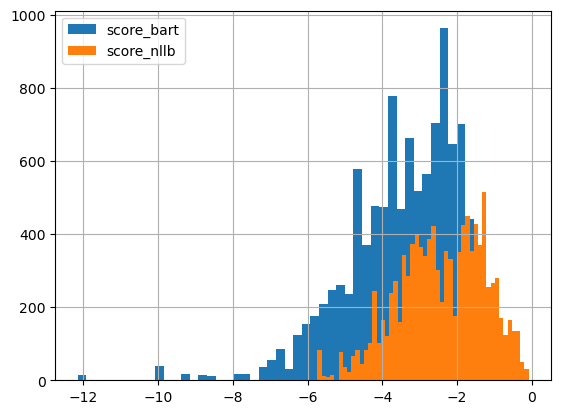

In [4]:
joined_df[joined_df.score_bart > -100].score_bart.hist(bins=50, legend=True)
joined_df[joined_df.score_nllb > -100].score_nllb.hist(bins=50, legend=True)

In [5]:
bo_bart_df = bart_df.set_index('bo')
bo_bart_df = bo_bart_df[~bo_bart_df.index.duplicated()]

bo_nllb_df = nllb_df.set_index('bo')
bo_nllb_df = bo_nllb_df[~bo_nllb_df.index.duplicated()]

bo_joined_df = bo_nllb_df.join(bo_bart_df, lsuffix='_nllb', rsuffix='_bart', how='inner')
bo_joined_df

,en_nllb,score_nllb,en_bart,score_bart
bo,,,,
།༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ།།,NaN,-100.000000,NaN,-100.000000
།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས་ཚོགས་རྣམས་ཐམས་ཅད་རབ་བཅོམ་སྟེ། །སྡེ་དང་བཅས་པའི་བདུད་རྣམས་ངེས་བཅོམ་ནས། །བྱང་ཆུབ་འདི་བརྙེས་དེ་ལ་ཕྱག་འཚལ་ལོ།,"homage to him who severed the bonds, destroyed...",-1.341003,"homage to him who severed the bonds, destroye...",-2.145057
།གཞི་རྣམས་ཀྱི་སྤྱི་སྡོམ་ལ། རབ་འབྱུང་གསོ་སྦྱོང་གཞི་དང་ནི།,the chapters on monastic discipline includes c...,-1.411704,the chapters on monastic discipline includes ...,-2.441791
།མངོན་དགའ་ཇི་བཞིན་དོན་བསྐྱེད་ཡང་དག་བྱེད་པ་དཀའ།,for the joyful set on perfection to act perfec...,-2.118942,for the joyful set on perfection to act perfe...,-4.802013
།དགག་དབྱེ་དབྱར་དང་ཀོ་ལྤགས་གཞི། །སྨན་དང་གོས་དང་སྲ་བརྐྱང་དང་། །ཀཽ་ཤཱམ་བཱི་དང་ལས་ཀྱི་གཞི། །དམར་སེར་ཅན་དང་གང་ཟག་དང་། །སྤོ་དང་གསོ་སྦྱོང་བཞག་པ་དང་། །གནས་མལ་དང་ནི་རྩོད་པ་དང་།།,"lifting restrictions, the rains, leather, medi...",-2.233428,"the rains, leather, medicine, robes, turning ...",-2.941920
...,...,...,...,...
རྟག་ཏུ་གནས་པ་དྲུག་གིས་གནས་པ། དབང་པོ་དྲུག་གི་སྒོ་བསྡམས་པ།,is well-grounded in his use of the four founda...,-2.645813,who teaches the four noble truths,-5.574857
འགྲོ་བ་ལྔ་ལས་ཡང་དག་པར་འདས་པ།,has crossed the four rivers,-2.990811,has crossed the four rivers,-5.696339
འཇིག་རྟེན་གྱི་ཆོས་བརྒྱད་ཀྱིས་མ་གོས་པ། ཀུན་ནས་མནར་སེམས་ཀྱི་དངོས་པོ་དགུ་ལ་མཁས་པ།,"who teaches the four noble truths who, being f...",-3.318365,"who, being fearless in four ways, is never fr...",-5.020300


In [6]:
(bo_joined_df.en_nllb == bo_joined_df.en_bart).sum()

22

In [7]:
i = 1

In [8]:
import os

from cai_garland.utils.translator import Translator

In [9]:
translator = Translator(os.path.join("olive-cormorant-nllb", "base-600M"))
# translator = Translator(os.path.join("olive-cormorant-bart", "base-base"))

translator.num_beams = 20
translator.decoding_length = 200

# translator.prepare_context_encoder("facebook/bart-base")

translator.cuda()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'NllbTokenizer'. 
The class this function is called from is 'CAINllbTokenizerFast'.


---

In [171]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index()[['en_nllb', 'en_bart']].loc[i].en_nllb

'that sentient beings acquire understanding and insight has nothing to do with causes and conditions'

In [172]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index().loc[i].score_nllb

-0.9137790203094482

In [173]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index()[['en_nllb', 'en_bart']].loc[i].en_bart

' that sentient beings acquire understanding and insight has nothing to do with causes and conditions'

In [174]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index().loc[i].score_bart

-1.8608790636062624

In [175]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].index[i]

'།སེམས་ཅན་རྣམས་ཤེས་པར་འགྱུར་བ་དང་། མཐོང་བར་འགྱུར་བ་ལ་རྒྱུ་མེད་རྐྱེན་མེད་དོ།'

In [176]:
translator.translate(bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].index[i])

/home/eeisenst/workspace/contribs/original/transformers/src/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


'knowing and seeing sentient beings has nothing to do with causes and conditions.'

In [177]:
# i += 1

import random

i = random.randrange(0, len(bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart]))
i

13

# Compare word counts

In [12]:
from cai_common.data import ParallelTMXLoader

In [13]:
parallel_df = ParallelTMXLoader() \
    .apply_markup() \
    .clean_bad_chars() \
    .dataframe

In [14]:
parallel_df = parallel_df.compute()
parallel_df

,filename,tohoku,folio,position,tibetan,english
0,Toh_384-Glorious_King_of_Tantras_That_Resolves...,384,F.187.a,1,དཔལ་རྡོ་རྗེ་སེམས་དཔའ་ལ་ཕྱག་འཚལ་ལོ། །,I pay homage to Glorious Vajrasattva!
1,Toh_384-Glorious_King_of_Tantras_That_Resolves...,384,F.187.a,39,འདི་སྐད་བདག་གིས་ཐོས་པའི་དུས་གཅིག་ན། །,Thus have I heard at one time.
2,Toh_384-Glorious_King_of_Tantras_That_Resolves...,384,F.187.a,204,དེ་ནས་བྱང་ཆུབ་སེམས་དཔའ་རྡོ་རྗེ་སྙིང་པོ་ལ་སོགས་...,"Then, the entourage, including bodhisattva Vaj..."
3,Toh_384-Glorious_King_of_Tantras_That_Resolves...,384,F.187.a,322,ཕྱི་ནང་གསང་བའི་མཆོད་པས་མཆོད་ནས་འདི་སྐད་ཅེས་གསོ...,"made outer, inner, and secret offerings, and a..."
4,Toh_384-Glorious_King_of_Tantras_That_Resolves...,384,F.187.a,388,ཀྱེ་ཧོ་བཅོམ་ལྡན་རྡོ་རྗེ་འཛིན། །,O Blessed Vajra Holder!
...,...,...,...,...,...,...
9482,Toh_99-The_Blessed_Ones_Wisdom_That_Leads_to_I...,99,F.275.b,,མཽད་གལ་གྱི་བུ་དེ་བཞིན་གཤེགས་པ་དགྲ་བཅོམ་པ་ཡང་དག...,"Maudgalyāyana, the thus-gone, worthy, perfect ..."
9483,Toh_99-The_Blessed_Ones_Wisdom_That_Leads_to_I...,99,F.275.b,,བཅོམ་ལྡན་འདས་ཀྱིས་དེ་སྐད་ཅེས་བཀའ་སྩལ་པ་དང་། ཚེ...,"When the Blessed One had spoken, venerable Mah..."
9484,Toh_99-The_Blessed_Ones_Wisdom_That_Leads_to_I...,99,F.275.b,,འཕགས་པ་བཅོམ་ལྡན་འདས་ཀྱི་ཡེ་ཤེས་རྒྱས་པའི་མདོ་སྡ...,"This completes the Great Vehicle sūtra, “ The ..."
9485,Toh_99-The_Blessed_Ones_Wisdom_That_Leads_to_I...,99,F.275.b,,རྒྱ་གར་གྱི་མཁན་པོ་པྲཛྙཱ་བར་མ་དང་། ལོཙྪ་བ་བན་དེ...,"This was translated by the Indian preceptor, P..."


In [16]:
parallel_df["tshegs"] = parallel_df.tibetan.str.count('་') + 1
parallel_df["spaces"] = parallel_df.english.str.count(' ') + 1

In [17]:
import numpy as np

(parallel_df.tshegs - parallel_df.spaces).describe(percentiles=np.arange(0.1, 1.01, 0.1))

count    166112.000000
mean          5.119395
std           8.436681
min        -112.000000
10%          -1.000000
20%           0.000000
30%           1.000000
40%           2.000000
50%           4.000000
60%           5.000000
70%           7.000000
80%           9.000000
90%          13.000000
100%        548.000000
max         548.000000
dtype: float64

In [18]:
(parallel_df.tshegs / parallel_df.spaces).describe(percentiles=np.arange(0.1, 1.01, 0.1))

count    166112.000000
mean          1.416946
std           0.580921
min           0.103448
10%           0.892857
20%           1.000000
30%           1.125000
40%           1.214286
50%           1.307692
60%           1.416667
70%           1.555556
80%           1.750000
90%           2.000000
100%         33.000000
max          33.000000
dtype: float64

<AxesSubplot: xlabel='diff', ylabel='ratio'>

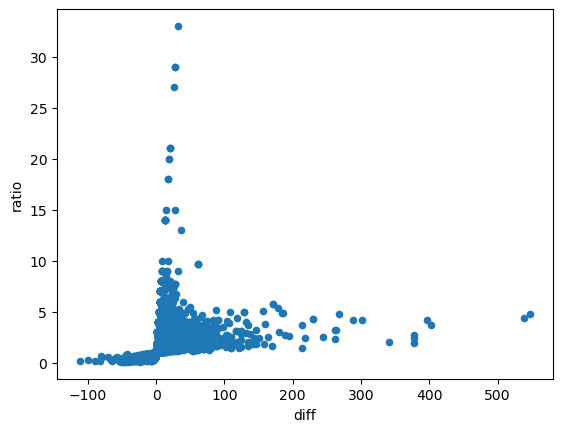

In [19]:
parallel_df['diff'] = parallel_df.tshegs - parallel_df.spaces
parallel_df['ratio'] = parallel_df.tshegs / parallel_df.spaces
parallel_df.plot.scatter(x='diff', y='ratio')

<AxesSubplot: xlabel='tshegs', ylabel='spaces'>

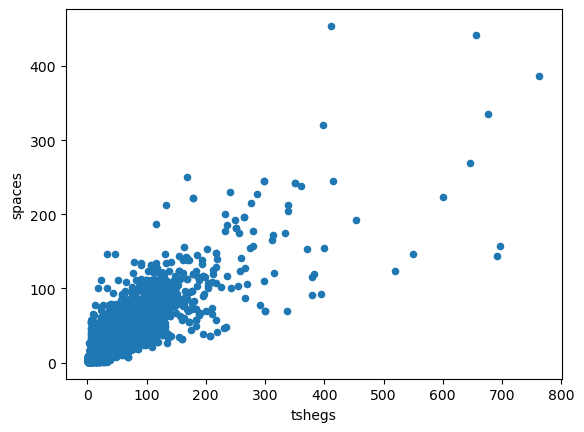

In [20]:
parallel_df.plot.scatter(x='tshegs', y='spaces')

<AxesSubplot: xlabel='spaces', ylabel='diff'>

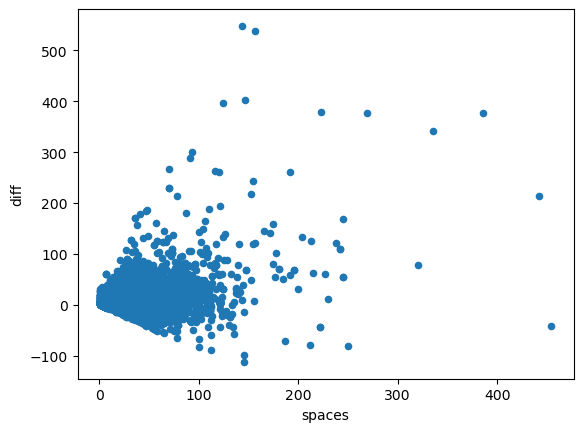

In [21]:
parallel_df.plot.scatter(x='spaces', y='diff')